In [1]:
from inspect import isfunction, ismethod, isgeneratorfunction, isgenerator, isroutine
from inspect import isabstract, isclass, ismodule, istraceback, isframe, iscode, isbuiltin
from inspect import ismethoddescriptor, isdatadescriptor, isgetsetdescriptor, ismemberdescriptor
from datetime import timedelta as _time
from datetime import datetime
from collections.abc import Iterable as iterable

def some(field): return (field is not None and field != [] and field != {} and field != ()) or field == True
def no(field): return not some(field) or field==False or field==''

class class_of:
    _instance = None
    def __init__(_, object):
        _._is = type(object)
    def inherits(_, *types):
        return issubclass(_._is, types)
    def has(_, *types): return _.inherits(*types)
    def __enter__(self):
        self._instance = self
        return self
    def __exit__(self, type, value, traceback): self._instance = None
    @staticmethod
    def each_in(list):
        if isiterable(list):
            return [type(item) for item in list]

class struct:
    def __init__(table, **sets): table.__dict__.update(sets)
    @property
    def sets(this): return set(dir(this)) - set(dir(type(this)))
    def set(object, **fields):
        for field in fields: setattr(object, field, fields[field])
    def get(object, *fields): return [getattr(object, field) for field in fields if field in object.__dict__]
    def _clonable(set, mask=None):
        check = set.__dict__.copy()
        clonable = check.copy()
        if some(mask): pass
#            for field in check:
#                if sum([int(_(check[field])) for _ in mask])+sum([int(_(field)) for _ in mask]): clonable.pop(field)
        return clonable
    @staticmethod
    def _from(type):
        if hasattr(type, '__dict__'): return struct(**type.__dict__.copy())
        return struct()

def meta(data, *mask): return struct._from(data)._clonable(mask)
def get(data, *fields):
    if not issubclass(type(data), dict): data=struct._from(data)._clonable()
    return struct(**data).get(*fields)

class table(struct):
    def _default(field, name, value):
        try: return getattr(field, name)
        except: setattr(field, name, value)
        return value
    def clear(this, *fields):
        sets = this.sets
        if not fields: fields = sets
        if fields:
            set = [field for field in fields if hasattr(this,field) and not ismethod(getattr(this, field))]
            for field in set: delattr(this, field)
    def has(this, *fields):
        return all([hasattr(this, field) for field in fields])
    def has_not(this, *fields): return not this.has(*fields)
    def check(this, **KV):
        try: check = [KV[key]==this.__dict__[key] for key in KV]
        except: return False
        return all(check)
    def find(this, _type):
        return [value for value in this.sets if class_of(get(this,value)[0]).inherits(_type)]
    def clone(this): 
        clone = type(this)()
        sets = this._clonable()
        clone.set(**sets)
        return clone

def isiterable(this): return isinstance(this, iterable) and type(this) is not str
def default(field, name, value): return table(**field)._default(name, value)

def ni(list):
    if isiterable(list):
        for n,i in enumerate(list): yield n,i
    else:
        for n,i in enumerate(list.__dict__.keys()): yield n,i

class at(table):
    DAY, HOUR, MIN = 86400, 3600, 60
    def __init__(_, dtime=None, **sets):
        _.set(**sets)
        if some(dtime) and issubclass(type(dtime), _time): _._time = dtime
        else:
            d,h,m,s,ms = _._default('d',0), _._default('h',0), _._default('m',0), _._default('s',0), _._default('ms',0)
            if not any([d,h,m,s,ms]): now=datetime.now(); _._time = now-datetime(now.year, now.month, now.day)
            else: _._time = _time(days=d, hours=h, minutes=m, seconds=s, milliseconds=ms)
        _.clear('d','h','m','s','ms')
    def __sub__(_, dtime):
        of=type(dtime); sets=_._clonable()
        if issubclass(of, _time): return at(_._time-dtime, **sets)
        elif issubclass(of, at): sets.update(dtime._clonable()); return at(_._time-dtime._time, **sets)
    def __add__(_, dtime):
        of=type(dtime); sets=_._clonable()
        if issubclass(of, _time): return at(_._time+dtime, **sets)
        elif issubclass(of, at): sets.update(dtime._clonable()); return at(_._time+dtime._time, **sets)
    def __str__(_): return str(_._time)
    @property
    def seconds(_): return _._time.seconds
    @property
    def S(_): return _.seconds
    @property
    def minutes(_): return _._time.seconds/60
    @property
    def M(_): return _.minutes
    @property
    def hours(_): return _.minutes/60
    @property
    def H(_): return _.hours
    @property
    def days(_): return _._time.days
    @property
    def D(_): return _.days
    @staticmethod
    def zero(): return at(_time())

from inspect import isfunction, ismethod, isgeneratorfunction, isgenerator, isroutine
from inspect import isabstract, isclass, ismodule, istraceback, isframe, iscode, isbuiltin
from inspect import ismethoddescriptor, isdatadescriptor, isgetsetdescriptor, ismemberdescriptor
from inspect import isawaitable, iscoroutinefunction, iscoroutine

from collections.abc import Iterable as iterable

import pickle

def isfx(field): return ismethod(field) or isfunction(field)

class GhostSet:
    """ enhanced interface (ghost) to retrieve class fields """
    def _meta(data): return {k:v for k,v in data.__dict__.items() if not isfx(v)}
    def _at_last(_, sets): pass
    def _set(object, **sets):
        ''' use to fast initialize fields | needed to avoid initialization problems at copy by value '''
        for field in sets: setattr(object, field, sets[field])
        object._at_last(sets)
GSet = GhostSet

def meta(object):
    ''' retrieves clonable object metadata (__dict__) as a copy '''
    if isinstance(object, GSet): return object._meta()
    return {}

class ClonableObjectGhost:
    """ enhanced interface (ghost) for clonable objects """
    def _by_val(_, depth=-1, _layer=0): pass
GCo = ClonableObjectGhost

class ClonableObject(GSet, GCo):
    """ base clonable object """
    def __init__(this, **data): this._set(**data)
    def __call__(_, **options): _._set(**options)
    def _by_val(_, depth=-1, _layer=0):
        copy = type(_)()
        copy._set(**_._meta())
        if depth<0 or depth>_layer:
            for field in copy.__dict__:
                if isinstance(copy.__dict__[field], ClonableObjectGhost):
                    copy.__dict__[field] = copy.__dict__[field]._by_val(depth,_layer+1)
        return copy
COb = ClonableObject

def copy_by_val(object, depth=-1, _layer=0):
    if isinstance(object, GCo): return object._by_val(depth,_layer)
    return object
copy = by_val = vof = copy_by_val

class ComparableGhost:
    """ enhanced interface (ghost) for comparing instances """
    def _compare(a, b):
        if type(a) != type(b): return False
        if a.__dict__ == b.__dict__: return True
        return False
    def __eq__(a, b): return a._compare(b)
GEq = ComparableGhost

class IterableObjectGhost(GSet):
    """ enhanced interface (ghost) for iterables: exposes __dict__,
        therefore Iterable Objects are like lua dictionaries """
    def __contains__(this, key): return key in this.__dict__
    def __iter__(this): return iter(this.__dict__)
    def items(my): return my.__dict__.items()
    def __getitem__(by, field): return by.__dict__[field]
    def __setitem__(by, field, value): by.__dict__[field] = value
    def pop(by, field): return by.__dict__.pop(field)
GIo = IterableObjectGhost

class ReprGhost:
    """ enhanced interface (ghost) for the skeleton method _repr,
        see implementation of Struct for a working example;
        Record __repr__ override uses _lines_ for max lines display """
    _lines_ = 31
    _chars_ = 13
    _msgsz_ = 62
    _ellipsis_ = ' ... '
    def _repr(my, value):
        _type = ''.join(''.join(str(type(value)).split('class ')).split("'"))
        _value = '{}'.format(value)
        if len(_value)>my._chars_:
            show = int(my._chars_/2)
            _value = _value[:show]+my._ellipsis_+_value[-show:]
        return '{} {}'.format(_type, _value)
    def _resize(this, message, at=.7):
        if len(message)>this._msgsz_:
            start = int(at*this._msgsz_)
            end = this._msgsz_-start
            return message[:start]+this._ellipsis_+message[-end:]
        return message
GRe = ReprGhost

def set_repr_to(lines): GRe._lines_ = lines

class Struct(COb, GEq, GIo, GRe):
    """ structured autoprintable object, behaves like a lua dictionary """
    def __repr__(_):
        return '\n'.join(['{}:\t{}'.format(k, _._repr(v)) for k,v in _.items()])
struct = Struct

class RecordableGhost:
    """ enhanced interface (ghost) for type recording,
        see Record for a working example """
    @staticmethod
    def load(filename):
        with open(filename, 'rb') as file: return pickle.load(file)
    def save(data, filename):
        with open(filename, 'wb') as file: pickle.dump(data, file)
        
GRec = RecordableGhost

class Record(GSet, GCo, GRec, GEq, GRe):
    """ wrapper for any object or value, auto-inspects and provides load/save type structure """
    data = None
    _check = dict(
            isfunction=isfunction, ismethod=ismethod, isgeneratorfunction=isgeneratorfunction, isgenerator=isgenerator, isroutine=isroutine,
            isabstract=isabstract, isclass=isclass, ismodule=ismodule, istraceback=istraceback, isframe=isframe, iscode=iscode, isbuiltin=isbuiltin,
            ismethoddescriptor=ismethoddescriptor, isdatadescriptor=isdatadescriptor, isgetsetdescriptor=isgetsetdescriptor, ismemberdescriptor=ismemberdescriptor,
            isawaitable=isawaitable, iscoroutinefunction=iscoroutinefunction, iscoroutine=iscoroutine
                   )
    def __init__(this, token, **meta):
        this.data = token
        this.__dict__.update({k:v(token) for k,v in this._check.items()})
        super()._set(**meta)
    @property
    def type(_): return type(_.data)
    def inherits(_, *types): return issubclass(_.type, types)
    @property
    def isbaseiterable(_): return _.inherits(tuple, list, dict, set) or _.isgenerator or _.isgeneratorfunction
    @property
    def isiterable(_): return isinstance(_.data, iterable) and _.type is not str
    def _clone_iterable(_):
        if _.inherits(dict): return _.data.copy()
        elif _.isgenerator or _.isgeneratorfunction: return (i for i in list(_.data))
        else: return type(_.data)(list(_.data)[:])
    def _meta(data): return {k:v for k,v in data.__dict__.items() if k != 'data' and not isfx(v)}
    def _by_val(_, depth=-1, layer=0):
        data = _.data
        if _.isiterable: data = _._clone_iterable()
        elif _.inherits(ClonableObjectGhost): data = by_val(data, depth, layer)
        return type(_)(data, **meta(_))
    def __enter__(self): self._instance = self; return self
    def __exit__(self, type, value, traceback): self._instance = None
    def __repr__(self):
        if not hasattr(self, '_preprint'): return Record(self.data, _preprint='', _lines=Record(Record._lines_)).__repr__()
        if self.isbaseiterable:
            pre, repr = self._preprint, ''
            for n,i in enumerate(self.data):
                if self._lines.data == 0: break
                else: self._lines.data -= 1
                index, item = str(n), i
                if self.inherits(dict): index += ' ({})'.format(str(i)); item = self.data[i]
                repr += pre+'{}: '.format(index)
                next = Record(item, _preprint=pre+'\t', _lines=self._lines)
                if next.isiterable: repr += '\n'
                repr += next.__repr__()
                repr += '\n'
            return repr
        elif self.inherits(GCo): return Record(self.data._meta(), _preprint=self._preprint, _lines=self._lines).__repr__()
        else: return self._repr(self.data)
REc = Record

class Bisect(list, COb):
    """ bisect implementation using clonable objects """
    def __init__(set, *items, key=None, reverse=False):
        if not key: key = lambda  x:x
        super().__init__(sorted(items, reverse=reverse, key=key))
    def _bisect(set, item, key, reverse, bottom, top):
        def _(check):
            if key: return key(check)
            return check
        at = int((top-bottom)/2)+bottom
        if len(set)==0: return (0,-1)
        if item==_(set[at]): return (at,0)
        bigger = item<_(set[at])
        if bigger != reverse:
            if at-bottom>0: return set._bisect(item, key, reverse, bottom, at)
            return (at,-1)
        elif top-at>1: return set._bisect(item, key, reverse, at, top)
        return (at,1)
    def search(_, item, key=None, reverse=False):
        if not key: key = lambda x:x
        return _._bisect(item, key, reverse, 0, len(_))
    def _by_val(_, depth=-1, _layer=0):
        copy = super()._by_val(depth, _layer)
        copy += _[:]
        return copy
BSx = Bisect

from numpy import ndarray, resize, linspace, arange
from numpy import min, max, average, floor
from numpy import ubyte, zeros, array
from scipy.signal import lfilter, butter
from matplotlib import pylab as lab

_NOTCH = _FR = 50
_SAMPLING = 500
_CONTINUOUS = 1
_UNIT = 'ms'

class rec(table, ndarray):
    @property
    def dimensions(of): return len(of.shape)
    @property
    def is_scalar(this): return this.shape is ()
    @property
    def is_vector(this): return len(this.shape)==1
    @property
    def is_matrix(this): return len(this.shape)>1
    @property
    def is_cube(this): return len(this.shape) == 3
    @property
    def is_binary(this): return this.dtype == ubyte and max(this) == 1
    @property
    def serialized(data):
        if not data.is_scalar and data.dimensions>1:
            return rec.read(data.T.flatten(), _deser=data.T.shape, **meta(data))
        return data
    @property
    def deserialized(data):
        if data.has('_deser'):
            deser = rec.read(resize(data, data._deser).T, **meta(data))
            deser.clear('_deser')
            return deser
        return data
    @property
    def as_matrix(data):    #implement numpy matrix
        if data.is_vector: return rec.read([data], to=type(data), **meta(data))
        return data
    @property
    def raw(data):
        if data.shape[0] == 1: return rec.read(data[0], **meta(data)).raw
        return data
    def join(base, *parts, **sets):
        flip, parts = None, list(parts)
        if 'flip' in sets: flip=sets.pop('flip')
        next = parts[0]
        if len(parts)>1: next = rec.join(parts[0], parts[1:])
        congruent = base.dimensions == next.dimensions and base.dimensions < 3
        if congruent:
            sets.update(base._clonable())
            A, B = base, next
            if flip: A, B = base.T, next.T
            C = record(A.tolist()+B.tolist(), **sets)
            if flip: return record(C.T, **sets)
            return C
    def get_as(this, data, cast=None):
        source = this
        if no(cast):
            if issubclass(type(data), rec): cast = type(data)
            else: cast = type(this)
        if issubclass(type(data), ndarray): source = resize(this, data.shape)
        return rec.read(source, to=cast, **meta(data))
    @staticmethod
    def read(iterable, to=None, **sets):
        if no(to) or not issubclass(to, rec): to = rec
        data = array(iterable).view(to)
        data.set(**sets)
        return data
    def clone(this, **sets):
        copy = this.copy().view(type(this))
        sets.update(this._clonable())
        copy.set(**sets)
        return copy
    def exclude(data, *items, **sets):
        if no(items) or data.is_scalar: return data
        excluded, items = None, [item for item in range(len(data)) if item not in items]
        if data.is_vector: excluded = rec.read([data])[:,items][0]
        else: excluded = data[items,:]
        return rec.read(excluded, to=type(data), **meta(data), **sets)
    def include(data, *items, **sets):
        if no(items) or data.is_scalar: return data
        included = []
        if data.is_vector: included = rec.read([data])[:,items][0]
        else: included = data[items,:]
        return rec.read(included, to=type(data), **meta(data), **sets)

create = record = rec.read
line = linspace

def series(ori,end=None,by=1):
    if no(end): end=ori; ori=0
    if not issubclass(type(by), int): return create(arange(ori,end,by))
    return array(range(ori,end,by))

def plot(data, at = 0., spacing = 1., color = 'k', width = 1., offset=0.): #review
    draw = record(data, **meta(data)); at = spacing*draw.as_matrix.shape[0]
    axes = lab.gca(); axes.set_ylim([at+max(data),0-max(data)]); at=0
    for n, row in ni(draw.as_matrix):
        if some(offset): row = draw[n]-average(row)+offset
        c, w = color, width
        if isiterable(color): c = color[n]
        if isiterable(width): w = width[n]
        lab.plot(at+row+n*spacing, color = c, linewidth = w)

def butter_type(lowcut, highcut, fs, order=5, type='band'):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=type)
    return b, a

def butter_filter(data, lowcut, highcut, fs, order=5, type='band'):
    b, a = butter_type(lowcut, highcut, fs, order=order, type=type)
    y = lfilter(b, a, data)
    return y

def _to_rec(this):
    if not issubclass(type(this), rec): return rec.read(this, **meta(this)), rec
    return this, type(this)

def _prefilt(data, fs):
    pre = []
    for line in data.as_matrix:
        vector = line.tolist()
        pre.append(vector[:int(fs)]+vector)
    return record(pre)

def _postfilt(data, fs):
    post = []
    for line in data:
        vector = line.tolist()
        post.append(vector[int(fs):])
    return post

def notch(this, using=butter_type, fs=_SAMPLING, size=2, at=_NOTCH, order=5):
    data, type = _to_rec(this)
    if data.has('sampling'): fs=data.sampling
    nyq, cutoff = fs / 2., []
    for f in range(int(at), int(nyq), int(at)):
        cutoff.append((f - size, f + size))
    signal = _prefilt(data, fs)
    for bs in cutoff:
        low,hi = bs
        b,a = butter_type(low,hi,fs,order,'bandstop')
        signal = lfilter(b,a,signal)
    return record(_postfilt(signal, fs), to=type, **meta(data))

def band(this, low_high, fs=_SAMPLING, using=butter_filter, order=5):
    data, type = _to_rec(this)
    if data.has('sampling'): fs=data.sampling
    low, high = min(low_high), max(low_high)
    if low<1.: low = 1.
    tailed = _prefilt(data, fs)
    tailed = using(tailed, low, high, fs, order)
    return rec.read(_postfilt(tailed, fs), to=type, **meta(data))

def binarize(this):
    data, type = _to_rec(this)
    if data.is_binary: return data
    rows = []
    for row in data.as_matrix:
        d = row - array([row[-1]]+row[:-1].tolist())
        d[d>=0] = 1; d[d<0] = 0
        rows.append(d.astype(ubyte))
    return rec.read(rows, to=type).get_as(data)

def halve(matrix):
    halved, (data, type) = [], _to_rec(matrix)
    for line in data.as_matrix:
        h = resize(line, (int(len(line)/2), 2))
        halved.append((h[:,0]+h[:,1])/2.)
    return rec.read(halved, to=type, **meta(data))

def dwindle(matrix, by=1):
    if by: return dwindle(halve(matrix), by-1)
    return matrix

def upsample(matrix, fs1, fs2):
    y=zeros((matrix.shape[0],fs2))
    if fs1 < fs2:
        #upsampling by a factor R
        L=matrix.shape[1]
        R=int(floor(fs2/fs1)+1)
        for i,e in enumerate(matrix):
            ups=[]
            for j in range(L-1):
                if j>0: ups.append(list(linspace(matrix[i][j],matrix[i][j+1],R)[1:3]))
                else: ups.append(list(linspace(matrix[i][j],matrix[i][j+1],R)[0:3]))
            for k,s in enumerate(sum(ups, [])): y[i][k]=s 
            y[i][-1]=y[i][-2]
        return rec.read(y)
    else: print("Error: fs1 >= fs2")

def remap(this, axis=None, base=0, top=1., e=0):
    def map(x, b, t, e): return ((x-min(x)+e)/(max(x)-min(x)+e)+b)*(t-b)
    data, type = _to_rec(this)
    if no(axis): return rec.read(map(this, base, top, e), to=type, **meta(data))
    rows = data.as_matrix
    if axis==0 or axis>1: rows = rows.T
    remapped = []
    for row in rows: remapped.append(map(row, base, top, e))
    if axis==0 or axis>1: rows = rows.T
    return rec.read(remapped).get_as(data)

<>:329: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:329: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_182945/1574426577.py:329: SyntaxWarning: "is" with a literal. Did you mean "=="?
  def is_scalar(this): return this.shape is ()


In [2]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import random

def classify_epochs(set, node_group, kratio=.1, random_state=31, **mopts):
    """Quantifies connectivity change of specified node group.
    The support vector machine classifies time frame epochs using the connectivity measures as features. 
    K-fold cross validation scores measure the connectivity change.

    Args:
        set (core.rec): Preprocessed data - connectivity matrices per epoch.
        nodes (set): Node group for which connectivity change is quantified. 
        kratio (float): Ratio of epochs considered in a fold. Defaults to 0.1, which is ~10s of data if epoch span is 1s.
        random_state (int): KFold argument; Controls randomness of each fold. Defaults to 31.

    Returns:
        ndarray of float: Array of scores for each fold.
    """
    X, Y = array([array((record(x).include(*node_group).T).include(*node_group)).flatten() for x in set.X]), set.y
    model, scaler, k = SVC, StandardScaler, int(round(len(Y)*kratio))
    if random_state == None: random_state = random.randint(0xFFFFFFFF)
    C = Pipeline([('scaler', scaler()), ('model', model(**mopts))])
    cv = KFold(k, shuffle=True, random_state=random_state)
    cvs = cross_val_score(C, X, Y, cv=cv)
    return cvs

def evaluate_nodes(nodes, labels, results, symbol='<->'):
    """Service function. 
    Creates sets with node indices, labels, cross validation scores.

    Args:
        nodes ([type]): [description]
        labels ([type]): [description]
        results (ndarray): Cross validation score array.
        symbol (str): Symbol used to connect node labels within a network. Defaults to '<->'.

    Returns:
        set: A set of all the arguments.
    """
    tag = symbol.join([labels[n] for n in nodes])
    return (nodes, tag, results)

In [13]:
main_folder = "/home/kivi/gdrive/epigame-folder/"

path_cm = main_folder + "connectivity_matrices/" 
path_net = main_folder + "selected_network/"

In [14]:
woi_code = {'1':"baseline", '2':"preseizure5", '3':"preseizure4", '4':"preseizure3", '5':"preseizure2", '6':"preseizure1", '7':"transition1", '8':"transition2", '9':"transition60", '10':"seizure"}
woi_code_inv = dict((v,k) for k, v in woi_code.items())

File: /home/kivi/gdrive/epigame-folder/connectivity_matrices/1-preseizure5-SCI-(0,4).prep
Connectivity matrices of 1
Number of nodes = 98

Nodes: ['D6-D7', 'B2-B3', 'U6-U7', 'T1-T2', 'M1-M2', 'G1-G2', 'A1-A2', 'Q10-Q11', 'E3-E4', 'P4-P5', 'L1-L2', 'L7-L8', 'T2-T3', 'O1-O2', 'P9-P10', 'B8-B9', 'A9-A10', 'Q1-Q2', 'U3-U4', 'Q3-Q4', 'U2-U3', 'J11-J12', 'Q11-Q12', 'M10-M11', 'C7-C8', 'E4-E5', 'P1-P2', 'B6-B7', 'F7-F8', 'C8-C9', 'B1-B2', 'L2-L3', 'T8-T9', 'G8-G9', 'E1-E2', 'L6-L7', 'A10-A11', 'P8-P9', 'C6-C7', 'F10-F11', 'E6-E7', 'E10-E11', 'G11-G12', 'A2-A3', 'U4-U5', 'J12-J13', 'T6-T7', 'M11-M12', 'J13-J14', 'J10-J11', 'O6-O7', 'F12-F13', 'T11-T12', 'F1-F2', 'T4-T5', 'T5-T6', 'E7-E8', 'C9-C10', 'G10-G11', 'D2-D3', 'A3-A4', 'E9-E10', 'D7-D8', 'C5-C6', 'M8-M9', 'Q2-Q3', 'D5-D6', 'J1-J2', 'O2-O3', 'Q8-Q9', 'M9-M10', 'T3-T4', 'B5-B6', 'E2-E3', 'A8-A9', 'F9-F10', 'P10-P11', 'L5-L6', 'Q9-Q10', 'C1-C2', 'B7-B8', 'U5-U6', 'F11-F12', 'O5-O6', 'T9-T10', 'J14-J15', 'A7-A8', 'E5-E6', 'E8-E9', 'U1-U2',

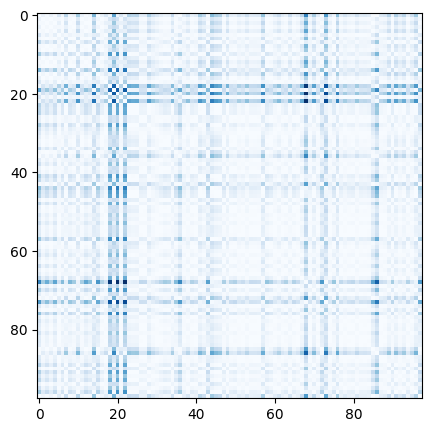

[[0.00000000e+00 6.51923396e-04 1.66113490e-04 ... 2.28342102e-03
  4.14492282e-03 4.42310167e-05]
 [6.51923396e-04 0.00000000e+00 1.71620164e-04 ... 5.27235762e-04
  1.55256030e-03 3.82663049e-04]
 [1.66113490e-04 1.71620164e-04 0.00000000e+00 ... 1.22775074e-03
  2.68260162e-03 4.76854892e-05]
 ...
 [2.28342102e-03 5.27235762e-04 1.22775074e-03 ... 0.00000000e+00
  2.93538938e-04 1.74309189e-03]
 [4.14492282e-03 1.55256030e-03 2.68260162e-03 ... 2.93538938e-04
  0.00000000e+00 3.41389076e-03]
 [4.42310167e-05 3.82663049e-04 4.76854892e-05 ... 1.74309189e-03
  3.41389076e-03 0.00000000e+00]]


In [17]:
from itertools import combinations
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

file_path = path_cm + "1-preseizure5-SCI-(0,4).prep"

print("File:", file_path)

filename = file_path.split("/")[-1]
subject_id = filename.split("-")[0]
woi = woi_code_inv[filename.split("-")[1]]
measure = filename.split("-")[2] if len(filename.split("-"))==4 else filename.split("-")[-1].split(".")[0]
bands = filename.split("-")[-1].split(".")[0] if len(filename.split("-"))==4 else None

print("Connectivity matrices of", subject_id)

cm = REc.load(file_path).data

nodes = cm.nodes
node_ids = list(range(len(nodes))) 
print("Number of nodes =",len(nodes))
print("\nNodes:", nodes)

print("\nTotal number of epochs =", len(cm.X))
print("Connectivity matrix shape =", cm.X[0].shape)
print("All matrices have the same shape:", all([m.shape==(len(nodes),len(nodes)) for m in cm.X]))
plt.figure(figsize=(5,5))
plt.imshow(cm.X[-1], cmap='Blues', interpolation='nearest')
plt.show()
print(cm.X[-1])

In [ ]:
node_pairs = combinations(node_ids, 2)

parallelize = Parallel(n_jobs=-1)(delayed(evaluate_nodes)(pair, nodes, classify_epochs(cm, pair)) for pair in node_pairs)
base = [p for p in parallelize]